## Load data

In [ ]:
import numpy as np
import pandas as pd
import os

dataroot = "data/"

X_train = np.load(os.path.join(dataroot, 'kmnist-train-imgs.npz'))['arr_0']
X_test = np.load(os.path.join(dataroot, 'kmnist-test-imgs.npz'))['arr_0']
y_train = np.load(os.path.join(dataroot, 'kmnist-train-labels.npz'))['arr_0']
y_test = np.load(os.path.join(dataroot, 'kmnist-test-labels.npz'))['arr_0']

## EDA

In [2]:
# Print data sizes
print("KMNIST train shape:", X_train.shape, y_train.shape)
print("KMNIST test shape:", X_test.shape, y_test.shape)

KMNIST train shape: (60000, 28, 28) (60000,)
KMNIST test shape: (10000, 28, 28) (10000,)


1. The data ratio between the train set and the test set is 6:1, so we decide to use 6-fold cross-validation.

2. The train set contains more than 10,000 data points, which is suitable for deep learning models.

In [3]:
X_train.dtype

dtype('uint8')

In [4]:
print("X_train min: {}, max: {}".format(X_train.min(), X_train.max()))

X_train min: 0, max: 255


Images are grayscale images. 

In [5]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


1. There are 10 classes in the dataset.
   
2. The classes are balanced, so tricks like weighted loss / resampling are not needed.

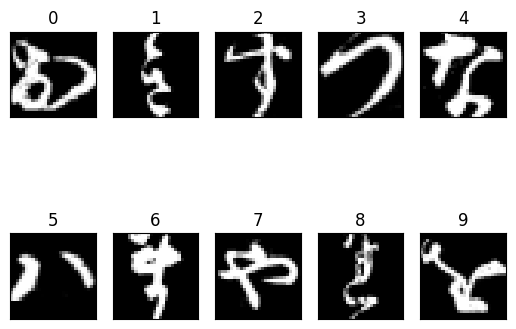

In [6]:
import matplotlib.pyplot as plt

for label in np.unique(y_train): 
    plt.subplot(2, 5, label+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[y_train == label][0], cmap='gray')
    plt.title(label)

1. Each class corresponds to a kind of hiragana. Our purpose is to classify them.
   
2. The image itself has low resolution, without complex background or textures. Therefore, a simple shallow CNN model should be enough to handle the task. 

## Preparation of Model Training

In [ ]:
from tensorflow import keras

# For the gray scale images, normalize them into range [0, 1], making training easier
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Reshape input data from (28, 28) to (28, 28, 1) to match input shape required by Conv2D layer
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

# One-hot encode the labels
y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test = keras.utils.to_categorical(y_test, len(np.unique(y_test)))

2025-01-12 17:30:11.857782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 17:30:12.586964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import random

# Make cross validation splits
skf = StratifiedKFold(n_splits=6, random_state=0, shuffle=True)

# Set random seeds
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

In [ ]:
# Build a simple CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_model(model_size, dropout, input_size, num_classes):
    model = Sequential()
    model.add(Conv2D(model_size, kernel_size=(3, 3), activation='relu', input_shape=(input_size, input_size, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(model_size, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Conv2D(model_size * 2, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization()) 
    model.add(Dropout(dropout))
    model.add(Conv2D(model_size * 2, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(dropout * 2))
    model.add(Dense(model_size * 4, activation='relu'))
    model.add(Dropout(dropout * 2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    return model

Due to the fact that this network only has 4 layers, it does not adopt designs such as feature pyramids or residual connections that are suitable for large image classification neural networks.

## Model Training

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
import hashlib

def train_and_cv(X_train, y_train, configs): 

    # Hash the configs for experiment management
    configs_hash = hashlib.md5(str(configs).encode()).hexdigest()

    print("Configs hash:", configs_hash)
    
    models = []
    histories = []
    train_accs = []
    val_accs = []
    val_preds = []
    val_inputs = []
    val_gts = []

    for i_fold, (train_index, val_index) in enumerate(skf.split(X_train, np.argmax(y_train, axis=1))):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        checkpoint = ModelCheckpoint("checkpoints/{}_{}.keras".format(configs_hash, i_fold), monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        model = build_model(configs["model_size"], configs["dropout"], X_train.shape[1], y_train.shape[1])
        history = model.fit(X_train_fold, y_train_fold, batch_size=configs["batch_size"], epochs=configs["epochs"], verbose=0, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint])
        model.load_weights("checkpoints/{}_{}.keras".format(configs_hash, i_fold))
        train_accs.append(accuracy_score(np.argmax(y_train_fold, axis=1), np.argmax(model.predict(X_train_fold), axis=1)))
        val_accs.append(accuracy_score(np.argmax(y_val_fold, axis=1), np.argmax(model.predict(X_val_fold), axis=1)))
        val_preds.append(model.predict(X_val_fold))
        val_inputs.append(X_val_fold)
        val_gts.append(y_val_fold)
        models.append(model)
        histories.append(history)

    val_preds = np.concatenate(val_preds)
    val_inputs = np.concatenate(val_inputs)
    val_gts = np.concatenate(val_gts)

    print("Train accuracy: {:.4f} +/- {:.4f}".format(np.mean(train_accs), np.std(train_accs)))
    print("Validation accuracy: {:.4f} +/- {:.4f}".format(np.mean(val_accs), np.std(val_accs)))

    # models: list of trained models from each fold
    # histories: list of training histories from each fold
    # val_preds: concatenated validation predictions from each fold
    # val_inputs: concatenated validation inputs from each fold
    # val_gts: concatenated validation ground truths from each fold
    return {"models": models, "histories": histories, "val_preds": val_preds, "val_inputs": val_inputs, "val_gts": val_gts, "hash": configs_hash}

We begin with the settings below: 

In [ ]:
configs = {
    'epochs': 100,
    'batch_size': 128, 
    'model_size': 32,
    'dropout': 0.1
}

results_lst = []
results_lst.append(train_and_cv(X_train, y_train, configs))

Configs hash: 20f8a0940f3991d8f129e1b6f7660730


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-12 17:30:13.767347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-12 17:30:13.815091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Docume

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train accuracy: 0.9997 +/- 0.0001
Validation accuracy: 0.9925 +/- 0.0005


By plotting the loss curves and accuracy curves of the training set and validation set, we can monitor the training process of the model.

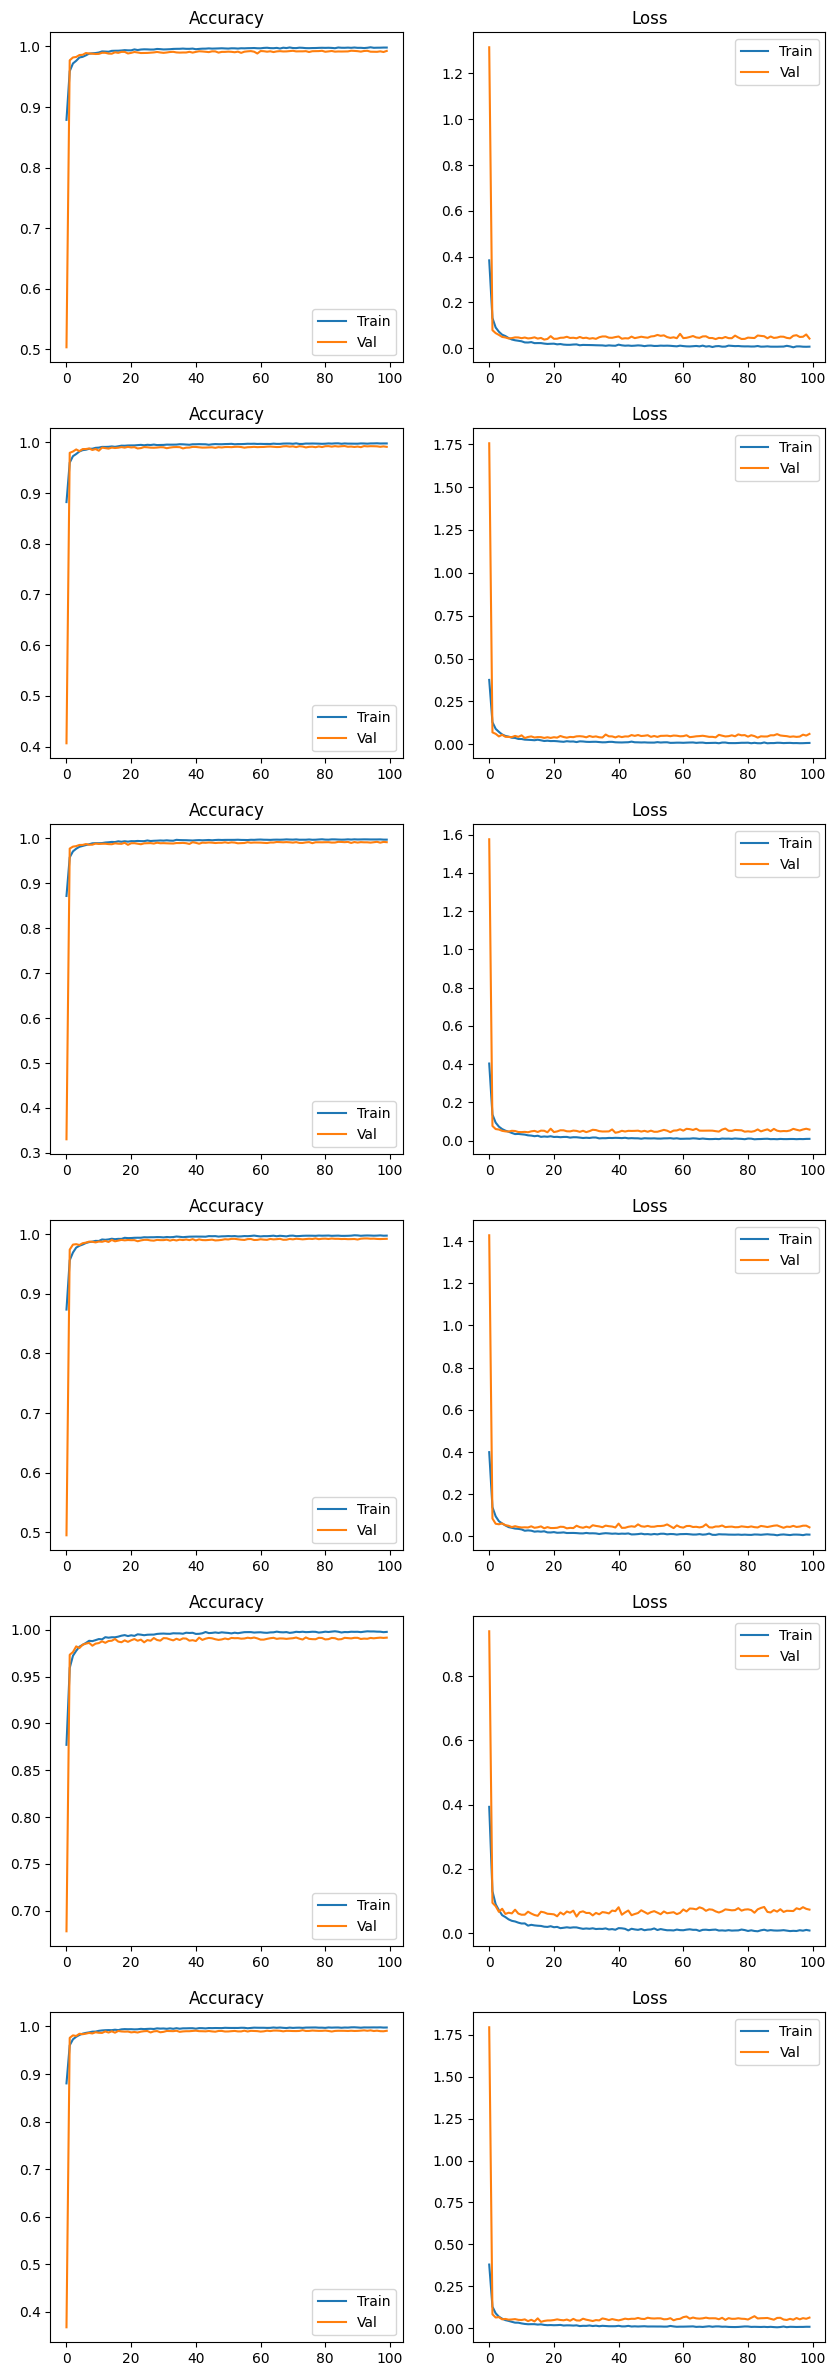

In [12]:
def plot_accuracy_and_loss(histories):
    f, ax = plt.subplots(6,2, figsize=(10, 30))
    for i, history in enumerate(histories):
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(train_accuracy))

        ax[i, 0].plot(epochs, train_accuracy, label='Train')
        ax[i, 0].plot(epochs, val_accuracy, label='Val')
        ax[i, 0].set_title('Accuracy')
        ax[i, 0].legend()
        ax[i, 1].plot(epochs, train_loss, label='Train')
        ax[i, 1].plot(epochs, val_loss, label='Val')
        ax[i, 1].set_title('Loss')
        ax[i, 1].legend()
    plt.show()
    
plot_accuracy_and_loss(results_lst[0]["histories"])

Although our model's performance on the training set improves as training proceeds, the performance improvement on the validation set has already stagnated early on, indicating that our model may be overfitting. We have tried to reduce overfitting by increasing the dropout rate.

In [13]:
configs["model_size"] = 32
configs["dropout"] = 0.2
results_lst.append(train_and_cv(X_train, y_train, configs))

Configs hash: cba453d59caed5b3ee49756d103e4a3c


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train accuracy: 0.9996 +/- 0.0001
Validation accuracy: 0.9935 +/- 0.0005


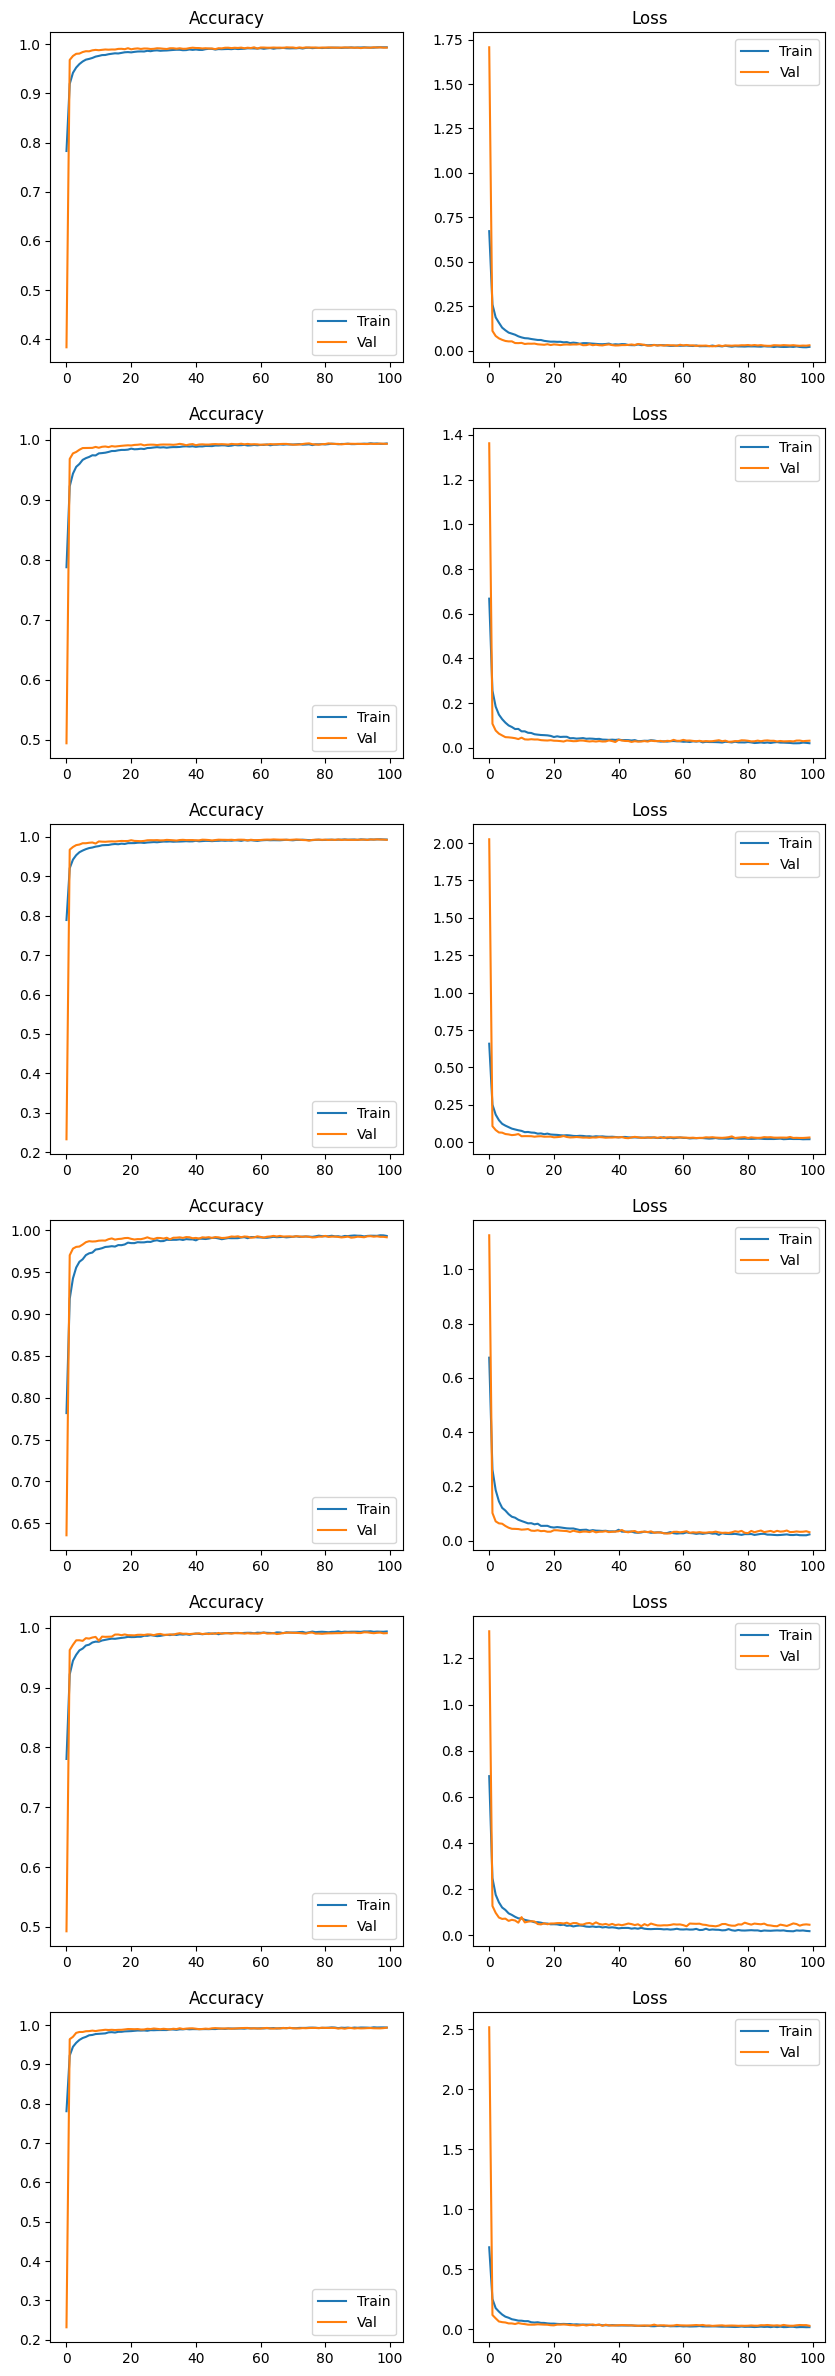

In [14]:
plot_accuracy_and_loss(results_lst[1]["histories"])

At this time, the over- fitting phenomenon has been improved to a certain extent, and the score on the verification set has also been improved.

## Model Evaluation and Improvement

We can check the performance of the model on the verification set through the confusion matrix to specifically understand the performance of the model in each category.

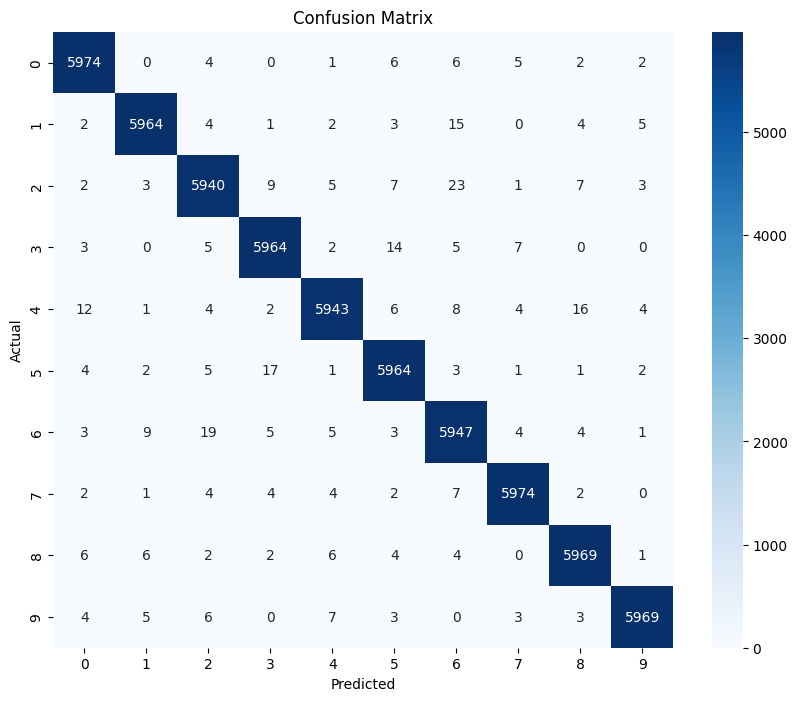

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    return cm

val_gts = np.argmax(results_lst[1]["val_gts"], axis = 1)
val_preds = np.argmax(results_lst[1]["val_preds"], axis = 1)

cm = plot_confusion_matrix(val_gts, val_preds)

It can be found that the model is prone to confusion when distinguishing between category 2 and category 6, as well as between category 3 and category 5. We visualize these two types of data and observe their characteristics.

In [16]:
def plot_wrong_samples(actual_cls, predicted_cls, val_inputs, val_gts, val_preds): 
    indices = ((val_gts == actual_cls) & (val_preds == predicted_cls))
    wrong_samples = val_inputs[indices]
    for i in range(len(wrong_samples)):
        plt.subplot(6, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(wrong_samples[i].reshape(28, 28), cmap='gray')
    plt.show()

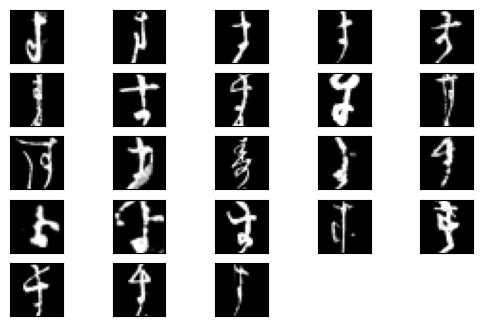

In [17]:
plot_wrong_samples(2, 6, results_lst[1]["val_inputs"], val_gts, val_preds)

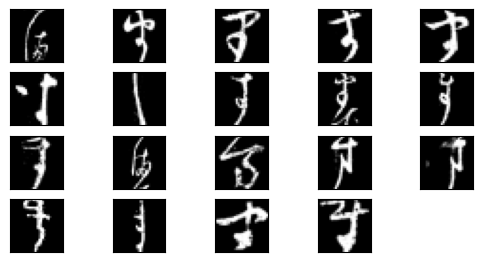

In [18]:
plot_wrong_samples(6, 2, results_lst[1]["val_inputs"], val_gts, val_preds)

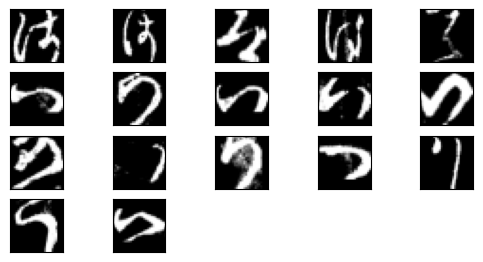

In [19]:
plot_wrong_samples(5, 3, results_lst[1]["val_inputs"], val_gts, val_preds)

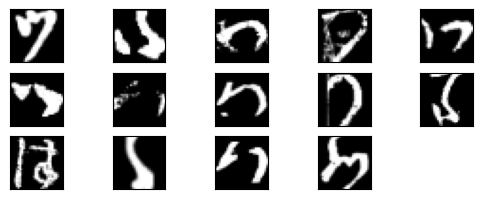

In [20]:
plot_wrong_samples(3, 5, results_lst[1]["val_inputs"], val_gts, val_preds)

These confusing images have similar morphological structures, and many examples are difficult to distinguish with the human eye. For the time being, we didn't think of using a simple feature engineering method to solve this problem, so we decided to try the model ensemble.

Specifically, for the categories 2 and 6 / 3 and 5, we train specialized models respectively. For the results predicted by the original model that fall into these categories, we input them into the specialized models to obtain the final prediction results.

In order to verify whether the specialized models' effectiveness in these categories can be higher than that of the original model, we first calculate the accuracy of the original model in these categories as a baseline.

In [21]:
cls1 = 2 
cls2 = 6
(cm[cls1, cls1] + cm[cls2, cls2]) / (cm[cls1, cls1] + cm[cls2, cls2] + cm[cls1, cls2] + cm[cls2, cls1])

0.9964791684131109

In [22]:
cls1 = 3
cls2 = 5
(cm[cls1, cls1] + cm[cls2, cls2]) / (cm[cls1, cls1] + cm[cls2, cls2] + cm[cls1, cls2] + cm[cls2, cls1])

0.99740781001756

## Training of Specialized Models

In [23]:
spec_results = {
    (2, 6): [], 
    (3, 5): []
}

In [ ]:
# Try a model with smaller size, since the data only contains two classes
configs["model_size"] = 16
configs["dropout"] = 0.2
configs["cls"] = (2, 6)

X_train_spec = X_train[(y_train.argmax(axis=1) == configs["cls"][0]) | (y_train.argmax(axis=1) == configs["cls"][1])]
y_train_spec = y_train[(y_train.argmax(axis=1) == configs["cls"][0]) | (y_train.argmax(axis=1) == configs["cls"][1])]

spec_results[configs["cls"]].append(train_and_cv(X_train_spec, y_train_spec, configs))

Configs hash: 10a91c709ee6a9f5a674a5ad99d10093


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train accuracy: 0.9999 +/- 0.0002
Validation accuracy: 0.9948 +/- 0.0010


In [25]:
configs["model_size"] = 16
configs["dropout"] = 0.2
configs["cls"] = (3, 5)

X_train_spec = X_train[(y_train.argmax(axis=1) == configs["cls"][0]) | (y_train.argmax(axis=1) == configs["cls"][1])]
y_train_spec = y_train[(y_train.argmax(axis=1) == configs["cls"][0]) | (y_train.argmax(axis=1) == configs["cls"][1])]

spec_results[configs["cls"]].append(train_and_cv(X_train_spec, y_train_spec, configs))

Configs hash: d1ec4899e76ad271da59283de869c6f3


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/harmonialeo/anaconda3/envs/kmnist/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train accuracy: 0.9997 +/- 0.0002
Validation accuracy: 0.9971 +/- 0.0009


We found that the performance of the specialized model in these two categories is not better than that of the original model, which may be because the amount of data in these two categories is relatively small, resulting in insufficient generalization ability of the model. Therefore, we decided to abandon the improvement plan this time.

If time permits, we can try to use data enhancement to increase the amount of data in these two categories, so as to improve the generalization ability of the model. 

From the perspective of the visualization of input data, data enhancement methods such as small-scale scaling, small-angle rotation, translation and tilt may be helpful.

## Testing

Finally, we use the models trained on the training set to predict the test set to see the final performance.

In [ ]:
# For the test set, we use the average predictions of trained models on all folds for ensembling
def ensemble_predict(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    stacked_predictions = np.stack(predictions, axis=0)
    avg_predictions = np.mean(stacked_predictions, axis=0)
    final_predictions = np.argmax(avg_predictions, axis=1)
    return final_predictions

models = results_lst[1]["models"]
predicted_classes = ensemble_predict(models, X_test)


y_true = np.argmax(y_test, axis=1)
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

print("Correct samples:", correct.shape[0])
print("Incorrect samples:", incorrect.shape[0])

  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Correct samples: 9811
Incorrect samples: 189
